# Ranked Version

In [1]:
import graspy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dask
import csv
from dask.distributed import Client, progress
import dask.dataframe as ddf
#uncomment when placed into model folder not doc
#from .base import BaseGraphEstimator, _calculate_p

from scipy.stats import bernoulli, mannwhitneyu, fisher_exact
from scipy import stats
from scipy.special import expit
import pandas as pd 
import mizani as miz

from graspy.simulations import sbm, er_np, er_nm
from graspy.plot import heatmap

import statsmodels.api as sm
import statsmodels.formula.api as smf

from graspy.models.base import BaseGraphEstimator 
from graspy.utils.utils import (
    augment_diagonal,
    cartprod,
    import_graph,
    is_unweighted,
    remove_loops,
    symmetrize,
)
import sys
import plotnine as p9
from dfply import *
%matplotlib inline

/Users/wilsontang/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
import sys
from os import path
import pandas as pd
import graspy

In [3]:
def cal_G(path):
    # Read in CSV file
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    result =[]
    for item in reader:
        result.append(item[0].split(" "))
    csvFile.close()
    
    G = np.zeros((70, 70))
    for i in range(len(result)):
        G[int(result[i][0])-1][int(result[i][1])-1] = float(result[i][2])
        G[int(result[i][1])-1][int(result[i][0])-1] = float(result[i][2])
     
    #G = graspy.utils.pass_to_ranks(G, method='simple-nonzero')
    return G

In [4]:
class SIEMEstimator(BaseGraphEstimator):
    """
    Stochastic Independent Edge Model
    
    Parameters
    ----------
    directed : boolean, optional (default=True)
        Whether to treat the input graph as directed. Even if a directed graph is inupt, 
        this determines whether to force symmetry upon the block probability matrix fit
        for the SBM. It will also determine whether graphs sampled from the model are 
        directed. 
    loops : boolean, optional (default=False)
        Whether to allow entries on the diagonal of the adjacency matrix, i.e. loops in 
        the graph where a node connects to itself. 
    n_components : int, optional (default=None)
        Desired dimensionality of embedding for clustering to find communities.
        ``n_components`` must be ``< min(X.shape)``. If None, then optimal dimensions 
        will be chosen by :func:`~graspy.embed.select_dimension``.
    min_comm : int, optional (default=1)
        The minimum number of communities (blocks) to consider. 
    max_comm : int, optional (default=10)
        The maximum number of communities (blocks) to consider (inclusive).
    cluster_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.cluster.GaussianCluster`
    embed_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.embed.AdjacencySpectralEmbed`
    Attributes
    ----------
    block_p_ : np.ndarray, shape (n_blocks, n_blocks)
        The block probability matrix :math:`B`, where the element :math:`B_{i, j}`
        represents the probability of an edge between block :math:`i` and block 
        :math:`j`.
    p_mat_ : np.ndarray, shape (n_verts, n_verts)
        Probability matrix :math:`P` for the fit model, from which graphs could be
        sampled.
    vertex_assignments_ : np.ndarray, shape (n_verts)
        A vector of integer labels corresponding to the predicted block that each node 
        belongs to if ``y`` was not passed during the call to ``fit``. 
    block_weights_ : np.ndarray, shape (n_blocks)
        Contains the proportion of nodes that belong to each block in the fit model.
    See also
    --------
    graspy.simulations.siem
    References
    ----------
    .. [1]  Holland, P. W., Laskey, K. B., & Leinhardt, S. (1983). Stochastic
            blockmodels: First steps. Social networks, 5(2), 109-137.
    """
    def __init__(
        self,
        directed=True,
        loops=False,
    ):
        super().__init__(directed=directed, loops=loops)
        self.model = {}

    def fit(self, graph, edge_comm, weighted=True):
        """
        Fit the SIEM to a graph
        Parameters
        ----------
        graph : array_like or networkx.Graph [nxn]
            Input graph to fit
        edge_comm : 2d list of k tuples (k_communities)
            Categorical labels for the block assignments of the graph
        weighted: boolean or float (default = True)
            Boolean: True - do nothing or False - ensure everything is 0 or 1
            Float: binarize and use float as cutoff
        """
        #checks
        n = graph.shape[0]
        if not(isinstance(graph, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph, np.ndarray))):
            msg = "graph must be a np.array or networkx.Graph"
            raise TypeError(msg)
        if not isinstance(edge_comm, list):
            msg = "Edge_comm must be a list"
            raise TypeError(msg)
        if len(edge_comm) >= n:
            msg = "warning more communities than n vertices"
            print(msg)
        if len(edge_comm) > n**2:
            msg = "Too many communities for this graph"
            raise TypeError(msg)
        if not(type(weighted) == bool or type(weighted) == float): 
            msg = "weighted must be a boolean or float"
            raise TypeError(msg)
        graph = import_graph(graph)
        if isinstance(weighted,float): 
            graph = 1*(graph>weighted)
        
        if weighted == False: 
            if not np.array_equal(graph, graph.astype(bool)):
                msg = "graph of weighted = False must have binary inputs"
                raise TypeError(msg)
                
        for i in range(0,len(edge_comm)):
            comms = []
            for x in edge_comm[i]:
                comms.append(graph[x])
                
            self.model[i] = np.array(comms)
        return
    
    def test(self, method=None, alternative="neq"):
        """
        Test whether there exists a difference in the edge weights from one
        community to another. This method should be called after fitting.
        Parameters
        ----------
        method: str, optional (default=None)
            The approach to use for testing. Options are:
                "wilcox": The Mann-Whitney Wilcox Test. For testing a stochastic difference between
                the edge distributions (specifically, a difference in medians), assuming the edge-communities
                follow a symmetric distribution. Number of unique communities in `self.model` 
                should be 2. The parameter `alternative` will specify the alternative hypothesis, 
                where the edge communities will be considered in the order given by `self.model.keys()`. The default if number of unique communities is two.
                "MGC": The Multiscale Generalized Correlation Test. For testing a difference in distribution
                across the edge distributions. Specifically, a k-sample test of whether the edge distributions
                differ.
        alternative: str, optional (default="neq")
            The alternative hypothesis for the test. This option is supported only
            in the event that the number of edge communities is 2. A warning will be passed
            if the number of communities exceeds 2, and an alternative hypothesis is specified.
            The possible options for an alternative hypothesis are "greater" (one-sided),
            "less" (one-sided), and "neq" (two-tailed).
            In the case that more than two communities are present, 
            `alternative` should be specified as `"neq"`.
        Returns
        -------
        T: float
            The test statistic
        pval: float
            The p-value associated with the test.
        method: str
            The method used for the test.
        alternative: str
            The alternative hypothesis for the test.
        """
        if not self.model:
            raise ValueError("You have not fit a model yet.")
        if (method == "wilcox" and len(self.model) != 2):
            msg = """wilcox rank-sum test can only be applied when the number
            of unique edge-communities is 2. Your data has {}.""".format(len(self.edge_comm))
            raise ValueError(msg)
        if (method is None) and (len(self.model.keys()) == 2):
            method = "wilcox"
        elif (method is None) and (len(self.model.keys()) > 2):
            method = "MGC"
            if (alternative != "neq"):
                msg = "You have specified an invalid alternative hypothesis. Setting to `neq`..."
                warnings.warn(msg)
                alternative = "two-sided"
        if not (method in ["wilcox"]):
            raise ValueError("You have not passed a supported method.")
        if (method == "wilcox" and alternative not in ["greater", "less", "neq"]):
            msg = "You have not specified a valid alternative. Taking to be neq (two-tailed)..."
            warnings.warn(msg)
            alternative = "two-sided"
        if method is "wilcox":
            if (alternative is None) or (alternative == "neq"):
                alternative = "two-sided"
            keys = list(self.model.keys())
            (tstat, pval) = mannwhitneyu(self.model[keys[0]], self.model[keys[1]],
                                              alternative=alternative)
        return (tstat, pval, method, alternative)


def siem(n, p, edge_comm, directed=False, loops=False, wt=None, wtargs=None,
        return_labels=False):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
    
    if return_labels:
        return (A, edge_comm)
    else:
        return A
    
def siem_two_sample_test(siem1, siem2, method="nonpar2", alternative="greater", nrep=100):
    """
    A function for the two-sample difference test for SIEM. Uses nonparametric
    permutation tests to account for model misspecification.
    
    Parameters
    ----------
    siem1: SIEMEstimator
        a fit SIEMEstimator.
    siem2: SIEMEStimator
        a fit SIEMEstimator.
    method: str (default="nonpar2")
        The method to use for the two-sample difference test.
        "nonpar2": a test for whether there is a difference in 2-community SIEMs with
        matched community names. Does not assume a distribution for the communities. Infers a pvalue
        using a nonparametric bootstrap. Hypothesis directionality will be interpreted using
        the given ordering of communities within each graph using the order of communities
        specified in the first graph; ie, siem1.model.keys().
    alternative: str (default="greater")
        the alternative hypothesis for the two-sample comparison test. Options are "greater",
        "less", and "neq".
    Returns
    -------
    tstat: float
        the observed test statistic.
    pval: float
        the p-value.
    null_tstat: array-like(float)
        the test statistics under the null for each iteration of the nonparametric bootstrap.
    """
    if not isinstance(siem1, SIEMEstimator):
        raise ValueError("siem1 is not of class SIEMEstimator.")
    if not isinstance(siem2, SIEMEstimator):
        raise ValueError("siem2 is not of class SIEMEstimator.")
    if not (method in ["nonpar2"]):
        raise ValueError("You have not passed a valid method.")
    if not (alternative in ["greater", "less", "neq"]):
        raise ValueError("You have not passed a valid alternative.")
    comms = list(siem1.model.keys())
    if not (set(comms) == set(siem2.model.keys())):
        raise ValueError("Your graphs should have identically-named communities.")
    if method == "nonpar2":
        N1_g1 = len(siem1.model[comms[0]])
        N2_g1 = len(siem1.model[comms[1]])
        N1_g2 = len(siem2.model[comms[0]])
        N2_g2 = len(siem2.model[comms[1]])
        edges1 = np.hstack((siem1.model[comms[0]], siem1.model[comms[1]]))
        edges2 = np.hstack((siem2.model[comms[0]], siem2.model[comms[1]]))
        tstat=mean((mean(siem1.model[comms[0]]) - mean(siem1.model[comms[1]])) -
                   (mean(siem2.model[comms[0]]) - mean(siem2.model[comms[1]])))
        null_tstat = np.empty((nrep))
        for i in range(nrep):
            null_siem1 = {comms[0]: np.random.choice(edges1, N1_g1),
                          comms[1]: np.random.choice(edges1, N2_g1)}
            null_siem2 = {comms[0]: np.random.choice(edges2, N1_g2),
                          comms[1]: np.random.choice(edges2, N2_g2)}
            
            null_tstat[i] = mean((mean(null_siem1[comms[0]]) - mean(null_siem1[comms[1]])) -
                                 (mean(null_siem2[comms[0]]) - mean(null_siem2[comms[1]])))
        if alternative == "greater":
            pval = np.mean(null_tstat > tstat)
        elif alternative == "less":
            pval = np.mean(null_tstat < tstat)
        else:
            tstat = np.abs(tstat)
            null_tstat = np.abs(null_tstat)
            pval = np.mean(null_tstat > tstat)
    return(tstat, pval, null_tstat)

In [5]:
def siem(n, p, edge_comm, directed=False, loops=False, wt=None, wtargs=None,
        return_labels=False):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
    
    if return_labels:
        return (A, edge_comm)
    else:
        return A

In [6]:
def modular_edges(n):
    """
    A function for generating modular sbm edge communities.
    """
    m = int(n/2)
    edge_comm = [[],[]]
    for i in range(n):
        for j in range(n):
            if ( (i<m) & (j<m)) or ( (i>=m ) & (j>=m) ):
                edge_comm[0].append((i,j))
            else:
                edge_comm[1].append((i,j))    
    return edge_comm

def diag_edges(n):
    """
    A function for generating diagonal SIEM edge communities.
    """
    m = int(n/2)
    edge_comm = [[],[]]
    for i in range(n):
        for j in range(n):
            if (i == j + m) or (j == i + m):
                edge_comm[0].append((i, j))
            else:
                edge_comm[1].append((i, j))
    return edge_comm

            
def modular_sbm(n, effect_size=0, weighted=False):
    """
    A function to generate edge assignments for a modular sbm.
    """
    edge_comm = modular_edges(n)
    if (weighted == False):
        mod = siem(n, [0.5 + effect_size/2, 0.5 - effect_size/2],
                   edge_comm=edge_comm, directed = True, loops = True,
                   return_labels=True)
    else:
        mod = siem(n, [1, 1],
                   edge_comm=edge_comm, directed = True, loops = True,
                   return_labels=True, wt=np.random.normal,
                    wtargs=[{"loc": 0.5 + effect_size/2, "scale": .5},
                            {"loc": 0.5 - effect_size/2, "scale": .5}])
    return mod

        
def diag_siem(n, effect_size=0, weighted=False):
    """
    A function to generate edge assignments for a diagonal siem.
    """
    edge_comm = diag_edges(n)
    if (weighted == False):
        mod = siem(n, [0.5 + effect_size/2, 0.5 - effect_size/2],
                   edge_comm=edge_comm, directed = True, loops = True,
                   return_labels=True)
    else:
        mod = siem(n, [1, 1],
                   edge_comm=edge_comm, directed = True, loops = True,
                   return_labels=True, wt=np.random.normal,
                    wtargs=[{"loc": 0.5 + effect_size/2, "scale": .5},
                            {"loc": 0.5 - effect_size/2, "scale": .5}])
    return mod

def gather_matrix(mtx, weighted="", gr_type=""):
    """
    Converts a matrix to a pandas dataframe
    """
    pd_mtx = pd.DataFrame(mtx)
    pd_mtx.columns = np.arange(1, mtx.shape[0] + 1, 1)
    pd_mtx >>= gather('Column', 'Weight', add_id=True)
    pd_mtx=pd_mtx.rename(columns={"_ID": "Row"})
    pd_mtx["Weighting"]=weighted
    pd_mtx["Method"] = gr_type
    pd_mtx["Row"] = pd_mtx["Row"] + 1
    return(pd_mtx)

In [7]:
#dmri_path='/Users/zhenhu/Documents/Second_semester/NDD_reading/dwi/dMRI_rank.csv'
#fmri_path = '/Users/zhenhu/Documents/Second_semester/NDD_reading/fMRI_ranked.csv'

In [8]:
dir1 = "s3_output_dwi_csv"
counter = 0
d_total1 = {i:{} for i in range(0, 100)}

In [9]:
for root, dirs, files in os.walk(dir1, topdown=True):
    parts = root.split('/')

    if files:
        file_parts = files[0].split('.')
        if file_parts[-1] == 'csv':
            counter = counter + 1
            file_name = files[0].split('_')
            #print('file name:', file_name)
            file_path = root+"/"+files[0]
            #print('file path:', file_path)
            G = cal_G(file_path)
            d = {'Subject':file_name[0].split('-')[-1],
                 'Dataset':parts[1],
                 'Session':file_name[1].split('-')[-1],
                 'G':G}
                        
            d_total1[counter-1] = d



In [10]:
dir2 = "func_output_csv"
counter = 0
d_total2 = {i:{} for i in range(0, 100)}

In [11]:
for root, dirs, files in os.walk(dir2, topdown=True):
    parts = root.split('/')
    
    if files:
        #print('files:', files)
        for file_name in files:
            file_parts = file_name.split('.')
            if file_parts[-1] == 'csv':
                counter = counter + 1

                name_parts = file_name.split('_')
                #print('file name:', name_parts)
                file_path = root+"/"+file_name
                #print('file path:', file_path)
                G = cal_G(file_path)
                d = {'Subject':name_parts[0].split('-')[-1],
                     'Dataset':parts[1],
                     'Session':name_parts[1].split('-')[-1],
                     'G':G}
                d_total2[counter-1] = d

In [12]:
n = 70
alpha = .05
ndmri = 100
nfmri = 100
# generate synthetic data
# dmris = {i: {'Subject': i, 'Dataset': np.random.randint(low=1, high=10),
#              'Session': 1, 'G': modular_sbm(n, effect_size=.03, weighted=True)[0]}
#          for i in range(0, ndmri)}
# fmris = {i: {'Subject': i, 'Dataset': np.random.randint(low=1, high=10),
#              'Session': 1, 'G': diag_siem(n, effect_size=.2, weighted=True)[0]}
#          for i in range(0, nfmri)}
dmris = d_total1
fmris = d_total2
#exps = {'SIEM': diag_edges(n), 'SBM': modular_edges(n)}
exps = {'SIEM': diag_edges(n), 'SBM': modular_edges(n)}
graphs = {'dMRI': dmris, 'fMRI': fmris}

# Within-Modality

Note: graphs should be RANKED

In [13]:
def fit_os_test(G, C):
    mod = SIEMEstimator()
    mod.fit(G, C)
    test = mod.test(alternative="greater")
    return test[0], test[1]

os_results = []
# iterate over each modality separately
for modality, mod_graphs in graphs.items():
    # grab the experiment and relevant edge community
    for exp, C in exps.items():
        for ind, datdict in mod_graphs.items():
            test = fit_os_test(datdict["G"], C)
            os_results.append([modality, exp, datdict["Dataset"], 
                               datdict["Subject"], datdict["Session"], 
                               test[0], test[1]])

os_results = pd.DataFrame(os_results, columns=["Modality", "Model", "Dataset", "Subject", "Session", "Tstat", "p_val"])
os_results["Group"] = os_results["Modality"] + os_results["Dataset"].astype(str)
os_results >>= group_by("Model") >> mutate(Tstat=(X.Tstat - np.min(X.Tstat))/(np.max(X.Tstat) - np.min(X.Tstat)))
os_results.head()

,Modality,Model,Dataset,Subject,Session,Tstat,p_val,Group
1194,dMRI,SBM,ABIDEII-BNI_1,29011,1,0.731551,8.513459e-272,dMRIABIDEII-BNI_1
1195,dMRI,SBM,ABIDEII-BNI_1,29014,1,0.723035,1.391289e-258,dMRIABIDEII-BNI_1
1196,dMRI,SBM,ABIDEII-BNI_1,29016,1,0.658585,2.945507e-211,dMRIABIDEII-BNI_1
1197,dMRI,SBM,ABIDEII-BNI_1,29018,1,0.659983,3.046109e-222,dMRIABIDEII-BNI_1
1198,dMRI,SBM,ABIDEII-BNI_1,29019,1,0.643956,8.200428e-203,dMRIABIDEII-BNI_1


In [14]:
#print(os_results['Group'].unique())

In [15]:
#os_results[os_results['Group']=='dMRIABIDEII-SDSU_1']

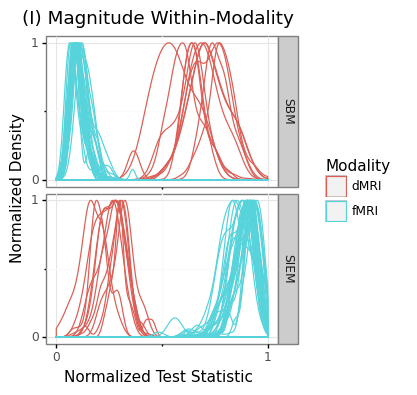

<ggplot: (7552572294)>

In [16]:
(p9.ggplot(data=os_results, mapping=p9.aes(x="Tstat", y="..scaled..", color="factor(Modality)", group="factor(Group)"))
 + p9.geom_density()
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Modality")
 + p9.scale_x_continuous(name="Normalized Test Statistic", breaks=[0, 1])
 + p9.scale_y_continuous(name="Normalized Density", breaks=[0, 1])
 + p9.theme_bw()
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(I) Magnitude Within-Modality")
)

In [17]:
os_results_dmri= os_results[os_results['Modality']== 'dMRI']
os_results_fmri= os_results[os_results['Modality']== 'fMRI']
print(os_results_dmri[os_results_dmri['Model']=='Homo-Hetero'])
os_results_dmri_1 = os_results_dmri[os_results_dmri['Model']=='Homo-Hetero']


Empty DataFrame
Columns: [Modality, Model, Dataset, Subject, Session, Tstat, p_val, Group]
Index: []


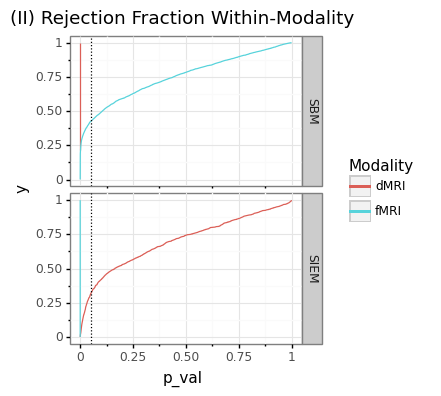

<ggplot: (7554199265)>

In [18]:
(p9.ggplot(data=os_results, mapping=p9.aes(x="p_val", color="factor(Modality)", group="factor(Modality)"))
 + p9.geom_line(stat="stat_ecdf")
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Modality")
#  + p9.scale_x_continuous(name="Threshold", limits=[.001, 1], breaks=[.001, .01, .1, 1], trans=miz.transforms.log10_trans)
#  + p9.scale_y_continuous(name="Fraction of Tests Rejected", breaks=[0, .5, 1])
 + p9.theme_bw()
 + p9.geom_vline(xintercept=.05, linetype="dotted")
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(II) Rejection Fraction Within-Modality")
)

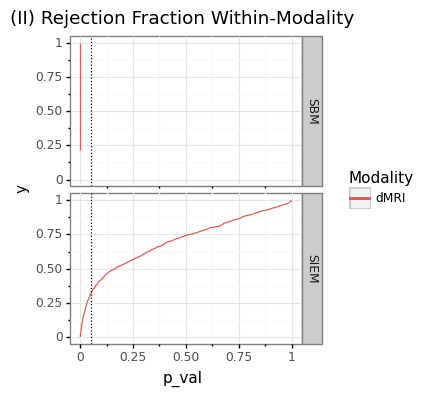

<ggplot: (7553527858)>

In [19]:
(p9.ggplot(data=os_results_dmri, mapping=p9.aes(x="p_val", color="factor(Modality)", group="factor(Modality)"))
 + p9.geom_line(stat="stat_ecdf")
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Modality")
#  + p9.scale_x_continuous(name="Threshold", limits=[.001, 1], breaks=[.001, .01, .1, 1], trans=miz.transforms.log10_trans)
#  + p9.scale_y_continuous(name="Fraction of Tests Rejected", breaks=[0, .5, 1])
 + p9.theme_bw()
 + p9.geom_vline(xintercept=.05, linetype="dotted")
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(II) Rejection Fraction Within-Modality")
)

In [20]:
(p9.ggplot(data=os_results_dmri_1, mapping=p9.aes(x="p_val", color="factor(Modality)", group="factor(Modality)"))
 + p9.geom_line(stat="stat_ecdf")
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Modality")
 + p9.scale_x_continuous(name="Threshold", limits=[.001, 1], breaks=[.001, .01, .1, 1], trans=miz.transforms.log10_trans)
 + p9.scale_y_continuous(name="Fraction of Tests Rejected", breaks=[0, .5, 1])
 + p9.theme_bw()
 + p9.geom_vline(xintercept=.05, linetype="dotted")
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(II) Rejection Fraction Within-Modality")
)

PlotnineError: 'Faceting variables must have at least one value'

/Users/wilsontang/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_ecdf : Removed 4377 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


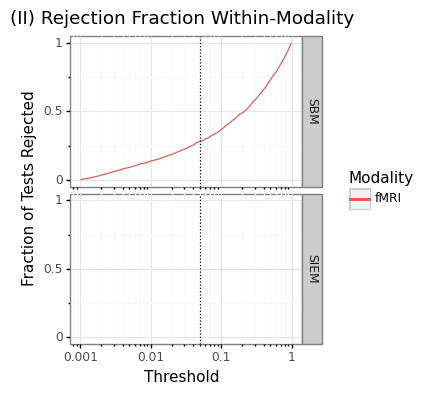

<ggplot: (-9223372036559542903)>

In [21]:
(p9.ggplot(data=os_results_fmri, mapping=p9.aes(x="p_val", color="factor(Modality)", group="factor(Modality)"))
 + p9.geom_line(stat="stat_ecdf")
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Modality")
 + p9.scale_x_continuous(name="Threshold", limits=[.001, 1], breaks=[.001, .01, .1, 1], trans=miz.transforms.log10_trans)
 + p9.scale_y_continuous(name="Fraction of Tests Rejected", breaks=[0, .5, 1])
 + p9.theme_bw()
 + p9.geom_vline(xintercept=.05, linetype="dotted")
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(II) Rejection Fraction Within-Modality")
)

# Betwixt Modality

Take careful note: for your case, you will need to prepare the data s.t. you have matched data for the
subject betwixt modalities

Again, rank ALL graphs before starting (important)

In [22]:
dir3 = "s3_output_dwi_func_csv"
counter = 0
d_total3 = {i:{} for i in range(0, 100)}

for root, dirs, files in os.walk(dir3, topdown=True):
    parts = root.split('/')
    print(dirs)
    if len(files) == 2:
        if '.DS_Store' not in files:
            #print('files:', files)
            parts1 = files[0].split('_')
            parts2 = files[1].split('_')
            #print(parts1, parts2)
            assert parts1[0]==parts2[0] and parts1[1]==parts2[1]
            counter = counter + 1
            file_path1 = root+"/"+files[0]
            file_path2 = root+"/"+files[1]
            if len(parts1) < len(parts2):
                G_func = cal_G(file_path1)
                G_dwi = cal_G(file_path2)
            else:
                G_func = cal_G(file_path2)
                G_dwi = cal_G(file_path1)
            d = {'Subject':parts1[0].split('-')[-1],
                 'Dataset':parts[1],
                 'Session':parts1[1].split('-')[-1],
                 'fMRI':G_func,
                 'dMRI': G_dwi}
            d_total3[counter-1] = d
            #print('counter:', counter, 'dict:', d)

['ABIDEII-BNI_1', 'ABIDEII-SDSU_1', 'ABIDEII-TCD_1', 'BNU1', 'BNU3', 'HNU1', 'MRN_1', 'SWU4']
['ABIDEII-BNI_1-m2g-dwi-04-15-20-csa-det-native']
['sub-29011', 'sub-29014', 'sub-29016', 'sub-29018', 'sub-29019', 'sub-29020', 'sub-29021', 'sub-29022', 'sub-29023', 'sub-29024', 'sub-29032', 'sub-29033', 'sub-29034', 'sub-29035', 'sub-29036', 'sub-29038', 'sub-29040', 'sub-29044', 'sub-29045', 'sub-29047', 'sub-29048', 'sub-29049', 'sub-29050', 'sub-29051', 'sub-29054', 'sub-29056', 'sub-30146', 'sub-30147', 'sub-30149']
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2'

['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x

[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-10', 'ses-2', 'ses-3', 'ses-4', 'ses-5', 'ses-6', 'ses-7', 'ses-8', 'ses-9']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['de

['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space

['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_spac

['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['connectomes']
['desikan_space-MNI152NLin6_res-2x2x2']
[]
['ses-1', 'ses-2']
['connectomes']
['desikan_space

In [23]:
ncomb = 100

# graphs = {i: {'Subject': i, 'Dataset': np.random.randint(low=1, high=10),
#              'Session': 1, 'fMRI': diag_siem(n, effect_size=.2, weighted=True)[0],
#              'dMRI': modular_sbm(n, effect_size=.03, weighted=True)[0]}
#          for i in range(0, ncomb)}
graphs = d_total3
# 
# graphs

In [26]:
def ts_test(G1, G2, C):
    m1 = SIEMEstimator()
    m1.fit(G1, C)
    m2 = SIEMEstimator()
    m2.fit(G2, C)
    test = siem_two_sample_test(m1, m2)
    return test[0], test[1]


ts_results = []
# grab the experiment and relevant edge community
for exp, C in exps.items():
    for ind, datdict in graphs.items():
        if exp == "SIEM":
            test = ts_test(datdict["fMRI"], datdict["dMRI"], C)
        else:
            test = ts_test(datdict["dMRI"], datdict["fMRI"], C)
        ts_results.append([exp, datdict["Dataset"], 
                           datdict["Subject"], datdict["Session"], 
                           test[0], test[1]])

ts_results = pd.DataFrame(ts_results, columns=["Model", "Dataset", "Subject", "Session", "Tstat", "p_val"])
#ts_results["Group"] = ts_results["Modality"] + ts_results["Dataset"].astype(str)
ts_results >>= group_by("Model") >> mutate(Tstat=(X.Tstat - np.min(X.Tstat))/(np.max(X.Tstat) - np.min(X.Tstat)))


In [ ]:
ts_results['Dataset'].values

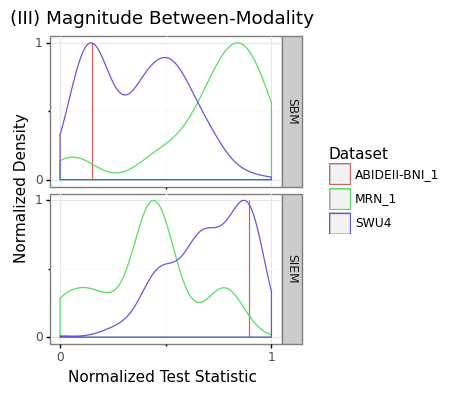

<ggplot: (-9223372029300000964)>

In [27]:
(p9.ggplot(data=ts_results, mapping=p9.aes(x="Tstat", y="..scaled..", color="factor(Dataset)", group="factor(Dataset)"))
 + p9.geom_density()
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name="Dataset")
 + p9.scale_x_continuous(name="Normalized Test Statistic", breaks=[0, 1])
 + p9.scale_y_continuous(name="Normalized Density", breaks=[0, 1])
 + p9.theme_bw()
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(III) Magnitude Between-Modality")
)

/Users/wilsontang/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


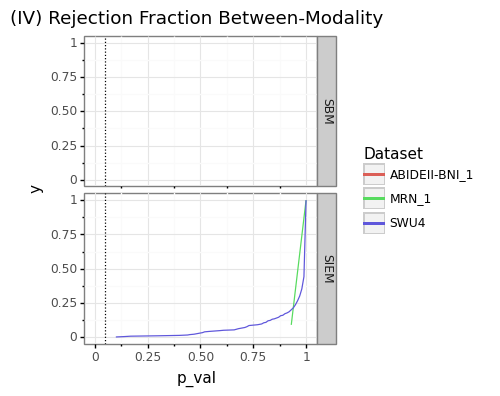

<ggplot: (-9223372029300579247)>

In [28]:
(p9.ggplot(data=ts_results, mapping=p9.aes(x="p_val", group="factor(Dataset)", color="factor(Dataset)"))
 + p9.geom_line(stat="stat_ecdf")
 + p9.facet_grid("Model~", scales="free_x")
 + p9.scale_color_discrete(name = 'Dataset')
#  + p9.scale_x_continuous(name="Threshold", limits=[.001, 1], breaks=[.001, .01, .1, 1], trans=miz.transforms.log10_trans)
#  + p9.scale_y_continuous(name="Fraction of Tests Rejected", breaks=[0, .5, 1])
 + p9.theme_bw()
 + p9.geom_vline(xintercept=.05, linetype="dotted")
 + p9.theme(figure_size=(3, 4))
 + p9.ggtitle("(IV) Rejection Fraction Between-Modality")
)